In this project, we aim at generating artistic images by transfering an image style to a given photo. 

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# we are using vgg-19 model
vgg = models.vgg19(pretrained = True)
vgg = vgg.features

# Freeze the weights
for parameters in vgg.parameters():
  parameters.requires_grad_(False)


vgg.to(device)

In [4]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  img_transforms = T.Compose([
                              T.Resize(size),
                              T.ToTensor(),
                              T.Normalize(mean = [0.485, 0.456, 0.406],
                                          std = [0.229, 0.224, 0.225])
  ])

  image = img_transforms(image)

  image = image.unsqueeze(0)
  return image

Preprocessing the Image:

In [69]:
#Let's process the content and style images. 
content_p = preprocess('/content/content_img.jpeg')
style_p = preprocess('/content/style.jpeg')

content_p = content_p.to(device)
style_p = style_p.to(device)


print('content shape', content_p.shape)
print('style shape', style_p.shape)

content shape torch.Size([1, 3, 500, 666])
style shape torch.Size([1, 3, 500, 1067])


De-Processing the Image:

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image


deprocessed content (500, 666, 3)


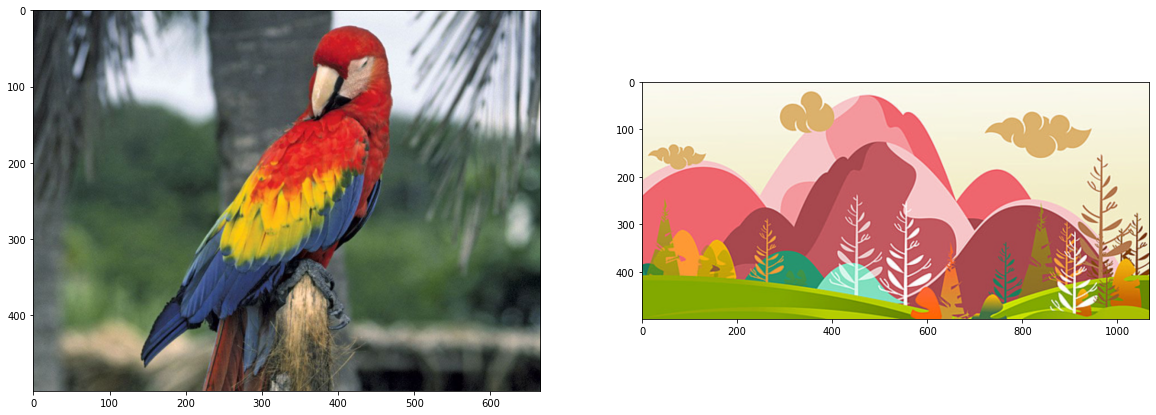

In [71]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print('deprocessed content', content_d.shape)


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.imshow(content_d)
ax2.imshow(style_d)

In [72]:
#Feature extraction:
def get_features(image, model):

  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2', # content feature
      '28': 'conv5_1'
  }

  x = image 

  Features = {}
  #load layers from vgg 19
  for name, layer in model._modules.items():
    x = layer(x)

    if name in layers:
      Features[layers[name]] = x
  
  return Features

In [73]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

In [74]:
def gram_matrix(tensor):

  b, c, h, w = tensor.size()

  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [75]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

Creating Style and Content loss function

In [76]:
def content_loss(target_conv4_2, content_conv4_2):

  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)
  return loss

In [77]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

In [78]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]

    b, c, h, w = target_f.shape

    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

    loss += layer_loss/(c*h*w)

  return loss

In [79]:
target = content_p.clone().requires_grad_(True).to(device)

target_f = get_features(target, vgg)

print('content loss', content_loss(target_f['conv4_2'], content_f['conv4_2']))
print('style loss', style_loss(style_weights, target_f, style_grams))

content loss tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
style loss tensor(1023.9995, device='cuda:0', grad_fn=<AddBackward0>)


In [80]:
from torch import optim


optimizer = optim.Adam([target], lr = 0.003)

alpha = 1
beta = 1e5

epochs = 3000

show_every = 500

def total_loss(c_loss, s_loss, alpha, beta):

  loss = alpha * c_loss + beta * s_loss
  return loss

In [81]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)

  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print('Total loss at epoch {}: {}'.format(i,t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0: 102399952.0
Total loss at epoch 500: 17782446.0
Total loss at epoch 1000: 9095282.0
Total loss at epoch 1500: 6230485.5
Total loss at epoch 2000: 4680581.0
Total loss at epoch 2500: 3657051.5


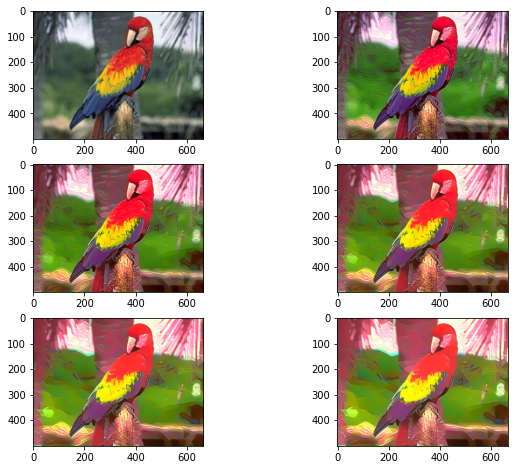

In [82]:
plt.figure(figsize = (10, 8))

for i in range(len(results)):

  plt.subplot(3,2, i+ 1)
  plt.imshow(results[i])
plt.show()

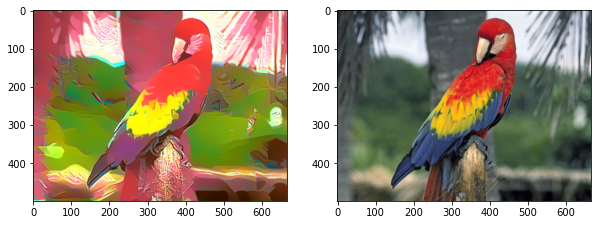

In [83]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)